# Xarxa Neuronal Bàsica amb MNIST

Aquest document ha estat creat per l'[Eric Alcaide](https://github.com/EricAlcaide). Crèdits a [Hvass-Labs](https://github.com/Hvass-Labs) pel codi en versió original i la implementació amb Tensorflow que ha estat modificat i traduït per als propòsits d'aquest treball.

## Introducció

Aquest arxiu ha estat creat amb l'objectiu de demostrar que els ordinadors poden aprendre. En aquest cas, entrenarem una xarxa neuronal bàsica per tal de reconèixer caràcters escrits a mà.

Primerament, carregarem el set de dades MNIST, un conjunt de 70.000 imatges de números escrits a mà amb la seva corresponent classificació. Aquestes 70.000 imatges es divideixen en: 55.000 imatges per entrenament, 5.000 imatges per a la validació i 10.000 més per a l'avaluament.
Posteriorment crearem el **model** (part del programa que serà l'encarregada "d'aprendre") amb Tensorflow, l'entrenarem per tal d'optimitzar la seva eficàcia i l'avaluarem. Posteriorment comentarem els resultats obtinguts i extreurem conclusions. 

Les llibreries/dependències que usarem seran les següents:
* **Numpy:** per tal de fer càlculs matemàtics 
* **Matplotlib:** per tal d'imprimir els gràfics i visualitzar les dades

## Definició del problema

Es tracta clarament d'un **problema de classificació** ja que a partir d'unes dades d'entrenament hem de ser capaços de classificar correctament unes dades que desconeixem. El nostre set d'imatges conté números que van del 0 al 9, per tant, són 10 números diferents. Això ens obliga a crear 10 classes diferents, una per a cada número.

Com el nostre propòsit és crear un model el més basic possible, crearem una xarxa neuronal amb 10 neurones, amb l'esperançca que cadascuna s'activi al reconèixer un dígit diferent diferent. Per tant, podem dir que la xarxa neuronal que anem a crear és de capa única. Per a aplicacions reals existeixen xarxes neuronals molt més sofisticades que aconsegueixen molt millors resultats com ara xarxes multicapa, recurrents, convolucionals, etc.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
print("Training:", len(mnist.train.labels), "Eval:", len(mnist.validation.labels), "Test:", len(mnist.test.labels))

Training: 55000 Eval: 5000 Test: 10000


## Codificació "One-Hot"

El set de dades MNIST ha estat carregat amb codificació "One-Hot", com podem veure aquí: ```one_hot=True```. Això significa que les etiquetes dels nombres han estat convertides d'un únic dígit (ex. 7), a un vector de 10 dimensions en el qual una d'elles és un 1 i les altres 0. Aquest tipus de codificació representa un avantatge per al càlcul de la funció de cost del nostre model.

In [4]:
print(mnist.test.labels[0:1, :]) # One-hot encoding example: 7

[[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]]


In [5]:
mnist.test.labels_mod = np.array([onehot.argmax() for onehot in mnist.test.labels])

In [12]:
size_img = 28                    # MNIST images are 28*28 px
img_flatten_size = size_img**2   # Flatten images into 28*28-dimensional vector
shape_img = (size_img, size_img) 
num_classes = 10                 # Number of different classes

In [15]:
def display_imgs(imgs, pred_class = None, true_class = None):
    # Create a 3*3 figure to display images.
    fig, axes = plt.subplots(1, 4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Print image.
        ax.imshow(imgs[i].reshape(shape_img), cmap='binary')
        # Display labels
        if pred_class and true_class:
            xlabel = "Pred class: {0}, True: {1}".format(pred_class[i], true_class[i])
            ax.set_xlabel(xlabel)
        # Remove x and y axis.
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

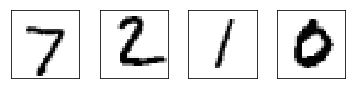

In [16]:
# Some MNIST examples
display_imgs(mnist.test.images[0:4])

## Variables del model

El nostre model serà senzill: una multiplicació de matrius i una suma que després passarem per la funció softmax. Aquesta funció retornarà els valors en una matriu de les mateixes dimensions de manera que tots els valors sumin 1.

La forma del nostre model serà de **softmax(w·x.T + b)**. Bàsicament es tracta d'un classificador linear (per tant amb la forma d'equació de la recta y = mx + n) on **w** serà la matriu dels pendents i **b** serà la matriu de desviacions de les rectes. 

In [18]:
# Initialize weights to small random values (noise) and biases to 0
weights = np.random.randn(num_classes, img_flatten_size)*0.02
biases = np.zeros((num_classes, 1))

In [17]:
def softmax(x):
    """ Compute softmax values for each sets of scores in x.
        All values add up to 1.
        Added - np.max(x) for numerical stability.
    """
    e_x = np.exp(x) - np.max(x)
    return e_x / e_x.sum()

## Loss and cost function


In [41]:
def loss(y, y_hat):
    return - np.sum(np.array(y)*np.log(np.array(y_hat)), axis=0)

def cost(Y, Y_HAT):
    return 1/len(Y)*(np.sum(loss(Y, Y_HAT), axis=0))

In [55]:
# Forward propagation of values
def forward_prop(weights, biases, X):
    z = np.dot(weights, X.T)+biases
    return softmax(z.T)

# Backward propagation of errors
def backprop(w, b, x, y, y_pred, batch_size, alpha):
    # Calculate cost
    cost_ = cost(y, y_pred)
    # Backpropagation - Calculate derivatives
    dz = y_pred - y
    dw = (1/batch_size) * np.dot(x.T,dz)
    db = (1/batch_size) * np.sum(dz, axis=0, keepdims=True)
    # Update weights and biases
    w -= alpha*dw.T
    b -= alpha*db.T
    return w,b

In [56]:
def manager(alpha, batches, batch_size, weights, biases):
    for i in range(batches):
        # Get the training batch
        x,y = mnist.train.next_batch(batch_size)
        # Forward pass - make predictions
        y_pred = forward_prop(weights, biases, x)
        # Backprop - update weights and biases
        weights, biases = backprop(weights, biases, x, y, y_pred, batch_size, alpha)
    
    return weights, biases

In [57]:
def eval_model(w,b,x,y):
    pred = np.argmax(forward_prop(w,b,x), axis=1)
    true_vals = np.array([onehot.argmax() for onehot in y])
    # Compare predicted and true values
    acc = np.sum(np.array([1 if pred[i]==true_vals[i] else 0 for i in range(len(pred))]), axis=0)/len(x)
    return "Accuracy: {0}%".format(acc*100)

In [58]:
# Initial test with all trainig images
val_size = len(mnist.test.labels)
x,y = mnist.test.next_batch(val_size)
eval_model(weights, biases, x, y)

'Accuracy: 4.95%'

In [59]:
def display_w(w):
    # Take min and max values to create a colormap
    p_min, p_max = np.min(w), np.max(w)

    # Create a figure
    fig, axes = plt.subplots(3,4)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        if i<10:
            # Take weights and reshape them to display
            image = w[i, :].reshape(size_img, size_img)
            # Declare the label
            ax.set_xlabel("Weights: {0}".format(i))
            # Show image. Blue points are positive, red ones are negative
            ax.imshow(image, vmin=p_min, vmax=p_max, cmap='seismic_r')
            
        # Remove x and y axis
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

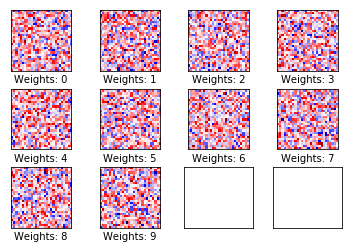

In [60]:
display_w(weights)

c:\users\eric\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


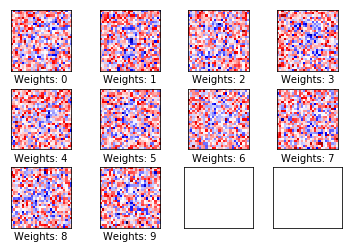

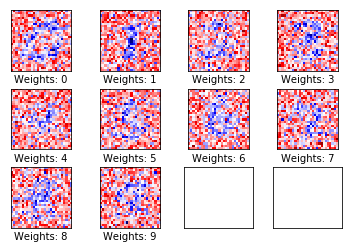

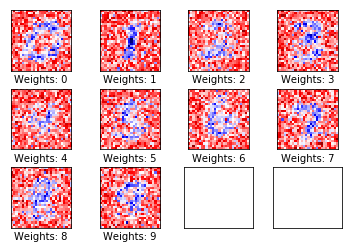

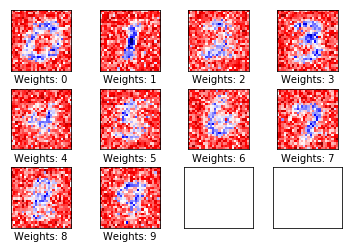

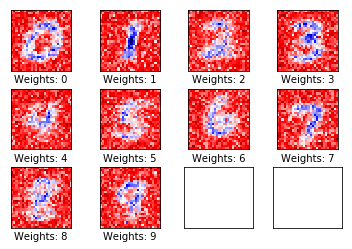

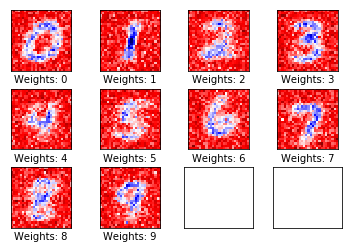

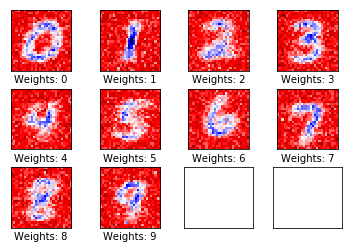

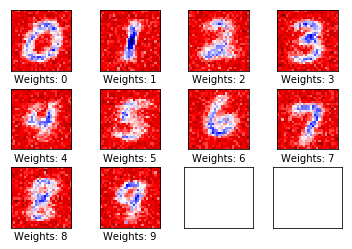

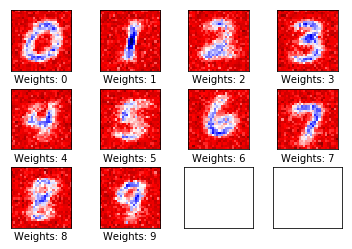

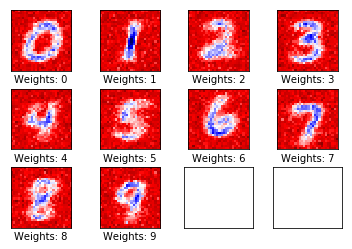

In [61]:
# Display the evolution
for i in range(10):
    weights, biases = manager(0.05, 5, 128, weights, biases)
    display_w(weights)

In [62]:
# Initial test with all trainig images
val_size = len(mnist.test.labels)
x,y = mnist.test.next_batch(val_size)
eval_model(weights, biases, x, y)

'Accuracy: 65.71000000000001%'